In [9]:
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import base64
from IPython import display as dd

import norse.torch.functional.stdp as stdp
from norse.torch import PoissonEncoder
from norse.torch import LIFParameters, LIFFeedForwardState
from norse.torch.module.lif import LIFCell
from norse.torch.functional.stdp import STDPState, STDPParameters

from DiehlAndCook2015 import DiehlLIFRecurrentCell, DiehlLIFParameters, DiehlLIFState

In [10]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

test_data = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

In [11]:
def new_diehl_lif_state(input_tensor, hidden_size, p, dv_th):
    _, batch_size, _, _, _ = input_tensor.shape
    dims = (batch_size, hidden_size)
    return DiehlLIFState(
        z=(
            torch.zeros(
                dims,
                device=input_tensor.device,
                dtype=input_tensor.dtype,
            ).to_sparse()
            if input_tensor.is_sparse
            else torch.zeros(
                dims,
                device=input_tensor.device,
                dtype=input_tensor.dtype,
            )
        ),
        v=torch.full(
            dims,
            torch.as_tensor(p.v_leak).detach(),
            device=input_tensor.device,
            dtype=torch.float32,
        ),
        i=torch.zeros(
            dims,
            device=input_tensor.device,
            dtype=torch.float32,
        ),
        dv_th=dv_th,
    )

In [12]:
class MNIST(nn.Module):
    def __init__(self, input_neurons: int, excitatory_neurons: int):
        super(MNIST, self).__init__()
        self.input_neurons = input_neurons
        self.excitatory_neurons = excitatory_neurons

        # 入力層から興奮層への全結合(weight: 0~1)
        inp_exc_weights = nn.Parameter(
            0.3 + 0.05 * torch.randn(self.excitatory_neurons, input_neurons)
        )
        # 抑制層から興奮層への結合(側方抑制)
        inh_exc_weights = nn.Parameter(
            -10.0
            * (
                torch.ones(self.excitatory_neurons, self.excitatory_neurons)
                - torch.diag(torch.ones(self.excitatory_neurons))
            )
        )
        # 興奮層から抑制層への結合(1対1)
        self.liner_exc_inh = nn.Linear(
            self.excitatory_neurons, self.excitatory_neurons, bias=False
        )
        self.liner_exc_inh.weight = nn.Parameter(
            5.0 * torch.diag(torch.ones(self.excitatory_neurons))
        )

        # 興奮層のニューロン
        self.lifcell_exc = DiehlLIFRecurrentCell(
            input_size=self.input_neurons,
            hidden_size=self.excitatory_neurons,
            p=DiehlLIFParameters(
                tau_syn_inv=torch.as_tensor(1 / 5e-3),
                tau_mem_inv=torch.as_tensor(1 / 50e-3),
                tau_v_th_inv=torch.as_tensor(1.0 / 1e3),
                v_leak=torch.as_tensor(0.0),
                v_th=torch.as_tensor(1.0),
                v_reset=torch.as_tensor(0.0),
                v_th_plus=torch.as_tensor(0.005),
                v_th_max=torch.as_tensor(10.0),
            ),
            input_weights=inp_exc_weights,
            recurrent_weights=inh_exc_weights,
        )

        # 抑制層のニューロン
        self.lifcell_inh = LIFCell(
            p=LIFParameters(
                tau_syn_inv=torch.as_tensor(1 / 5e-3),
                tau_mem_inv=torch.as_tensor(1 / 10e-3),
                v_leak=torch.as_tensor(0.0),
                v_th=torch.as_tensor(0.5),
                v_reset=torch.as_tensor(0.0),
            )
        )

        # STDP用のパラメータ
        self.stdp_parameter = STDPParameters(
            tau_pre_inv=torch.as_tensor(1.0 / 50e-3),
            tau_post_inv=torch.as_tensor(1.0 / 50e-3),
            w_min=0.0,
            w_max=1.0,
            eta_plus=torch.as_tensor(1e-2),
            eta_minus=torch.as_tensor(1e-4),
            stdp_algorithm="additive_step",
            hardbound=False,
        )
        self.norm = 100
        self.dv_th = nn.Parameter(torch.zeros((1, self.excitatory_neurons)))

    def forward(self, x: torch.Tensor, train: bool):
        time, batch_size, _, _, _ = x.shape
        with torch.no_grad():
            if train:
                state_exc = new_diehl_lif_state(
                    x, self.excitatory_neurons, self.lifcell_exc.p, self.dv_th
                )
                state_inh = None
                state_stdp = STDPState(
                    t_pre=torch.zeros(self.input_neurons, device=x.device),
                    t_post=torch.zeros(self.excitatory_neurons, device=x.device),
                )
                for t in range(time):
                    z_pre = x[t, :, :, :].view(-1, self.input_neurons)
                    z_post, state_exc = self.lifcell_exc(z_pre, state_exc)
                    z = self.liner_exc_inh(z_post)
                    z, state_inh = self.lifcell_inh(z, state_inh)
                    state_exc = state_exc._replace(z=z)

                    w, state_stdp = stdp.stdp_step_linear(
                        z_pre=z_pre,
                        z_post=z_post,
                        w=self.lifcell_exc.input_weights,
                        state_stdp=state_stdp,
                        p_stdp=self.stdp_parameter,
                    )

                    w = self.norm * w / torch.sum(w, dim=1, keepdim=True)
                    self.lifcell_exc.input_weights.data = w

                self.dv_th = nn.Parameter(
                    torch.sum(state_exc.dv_th, dim=0, keepdim=True)
                )
                return w

            else:
                state_exc = new_diehl_lif_state(
                    x, self.excitatory_neurons, self.lifcell_exc.p, self.dv_th
                )
                state_inh = None
                firing_rate = torch.zeros(
                    (batch_size, self.excitatory_neurons), device=x.device
                )
                for t in range(time):
                    z = x[t, :, :, :].view(-1, self.input_neurons)
                    z, state_exc = self.lifcell_exc(z, state_exc)
                    firing_rate += z
                    z = self.liner_exc_inh(z)
                    z, state_inh = self.lifcell_inh(z, state_inh)
                    state_exc = state_exc._replace(z=z)
                return firing_rate

    def save(self, file_path: str = "./mnist_model_parameters.pth"):
        torch.save(self.state_dict(), file_path)

    def load(self, file_path: str = "./mnist_model_parameters.pth"):
        self.load_state_dict(torch.load(file_path))

In [13]:
def visualize_tensor_as_grid(
    tensor: torch.Tensor,
    grid_rows: int,
    grid_cols: int,
    image_size: int = 28,
    save_path: str = None,
):
    """
    テンソルを指定された行数と列数のグリッドに変換して保存する関数。

    Args:
        tensor (torch.Tensor): 表示するテンソル
        grid_rows (int): グリッドの行数
        grid_cols (int): グリッドの列数
        image_size (int, optional): 画像のサイズ。デフォルトは28。
        save_path (str, optional): 画像を保存するパス。デフォルトはNone。

    Returns:
        None
    """
    # 勾配を切り離してテンソルをnumpy配列に変換
    tensor = tensor.to("cpu").detach().numpy()

    # 画像を配置するキャンバスの初期化
    canvas = np.zeros((grid_rows * image_size, grid_cols * image_size))

    # テンソルを画像に変換し、キャンバスに配置
    for i in range(grid_rows):
        for j in range(grid_cols):
            idx = i * grid_cols + j
            if idx < tensor.shape[0]:  # インデックスがテンソルの範囲内か確認
                image = tensor[idx].reshape(image_size, image_size)
                canvas[
                    i * image_size : (i + 1) * image_size,
                    j * image_size : (j + 1) * image_size,
                ] = image

    # カスタムカラーマップの作成
    cmap = LinearSegmentedColormap.from_list(
        "custom_cmap", [(0, "black"), (1, "green")]
    )

    # 画像を保存
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas, cmap=cmap)
    plt.axis("off")
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.close()

In [14]:
seed = 0
gpu = True

# GPU使用の設定
if gpu and torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(seed)
else:
    device = torch.device("cpu")
    torch.manual_seed(seed)
    torch.set_num_threads(os.cpu_count() - 1)

In [15]:
# 中間層のニューロンの一辺の数
excitatory_neurons = 20

In [16]:
# オンライン学習
BATCH_SIZE = 1
EPOCH = 3
TIME = 350
interval = 100
save_interval = 10000
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)
encoder = PoissonEncoder(TIME, f_max=64)

model = MNIST(28 * 28, excitatory_neurons**2)
model.to(device)
for j in tqdm(range(EPOCH), desc="Epoch"):
    for i, (data, target) in enumerate(tqdm(train_loader, desc="Training")):
        data = encoder(data).to(device)
        data = torch.cat((data, torch.zeros(150, 1, 1, 28, 28).to(device)), dim=0)
        w = model(data, True)
        if i % interval == 0:
            visualize_tensor_as_grid(
                w,
                excitatory_neurons,
                excitatory_neurons,
                save_path=f"./weight/image_{int(i/interval+60000/interval*j)}.png",
            )
        if i * BATCH_SIZE % save_interval == 0:
            model.save(f"./save/{i*BATCH_SIZE+60000*j}.pth")

model.save("./mnist_model_parameters.pth")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

In [17]:
class LabelAssignment:
    def __init__(
        self,
        n_labels: int,
        n_neurons: int,
        device: str,
    ):
        self.n_labels = n_labels
        self.n_neurons = n_neurons
        self.rates = torch.zeros((n_neurons, n_labels), device=device)
        self.proportions = torch.zeros((n_neurons, n_labels), device=device)
        self.assignments = torch.zeros(n_neurons, device=device)

    def assign_labels(self, firing_rate, target):
        for i in range(self.n_labels):
            n_labeled = torch.sum(target == i).float()
            if n_labeled > 0:
                indices = torch.nonzero(target == i).view(-1)
                self.rates[:, i] = self.rates[:, i] + (
                    torch.sum(firing_rate[indices], 0) / n_labeled
                )
        self.proportions = self.rates / self.rates.sum(1, keepdim=True)
        self.proportions[self.proportions != self.proportions] = 0
        self.assignments = torch.max(self.proportions, 1)[1]
        return

    def all_activity(self, firing_rate):
        n_samples = firing_rate.size(0)
        rates = torch.zeros((n_samples, self.n_labels), device=firing_rate.device)
        for i in range(self.n_labels):
            n_assigns = torch.sum(self.assignments == i).float()
            if n_assigns > 0:
                indices = torch.nonzero(self.assignments == i).view(-1)
                rates[:, i] = torch.sum(firing_rate[:, indices], 1) / n_assigns
        return torch.sort(rates, dim=1, descending=True)[1][:, 0]

    def proportion_weighting(self, firing_rate):
        n_samples = firing_rate.size(0)
        rates = torch.zeros((n_samples, self.n_labels), device=firing_rate.device)
        for i in range(self.n_labels):
            n_assigns = torch.sum(self.assignments == i).float()
            if n_assigns > 0:
                indices = torch.nonzero(self.assignments == i).view(-1)
                rates[:, i] += (
                    torch.sum((self.proportions[:, i] * firing_rate)[:, indices], 1)
                    / n_assigns
                )
        predictions = torch.sort(rates, dim=1, descending=True)[1][:, 0]
        return predictions

In [18]:
model_path = "./mnist_model_parameters.pth"

In [19]:
# ラベル付け
BATCH_SIZE = 1000
TIME = 350
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False
)
encoder = PoissonEncoder(TIME, f_max=64)

label = LabelAssignment(10, excitatory_neurons**2, device)

model = MNIST(28 * 28, excitatory_neurons**2)
model.load(model_path)
model.to(device)
for i, (data, target) in enumerate(tqdm(train_loader, desc="Label Assigments")):
    data = encoder(data).to(device)
    firing_rate = model(data, False)
    label.assign_labels(firing_rate, target)

print(label.assignments)

Label Assigments:   0%|          | 0/60 [00:00<?, ?it/s]

tensor([0, 0, 6, 8, 3, 6, 6, 5, 4, 3, 8, 0, 0, 0, 8, 6, 1, 1, 8, 8, 8, 3, 1, 6,
        6, 3, 0, 0, 6, 5, 6, 0, 0, 6, 7, 5, 0, 0, 8, 8, 6, 6, 3, 9, 8, 0, 0, 6,
        0, 5, 3, 8, 2, 6, 6, 6, 8, 9, 6, 6, 5, 0, 6, 0, 0, 6, 7, 8, 6, 3, 6, 9,
        9, 0, 0, 4, 0, 3, 6, 0, 9, 3, 0, 0, 8, 7, 0, 0, 0, 3, 8, 8, 3, 0, 0, 6,
        8, 9, 8, 3, 6, 0, 0, 2, 8, 0, 3, 3, 6, 0, 3, 8, 8, 9, 3, 2, 3, 3, 8, 2,
        6, 3, 3, 3, 4, 0, 3, 0, 0, 3, 0, 0, 0, 2, 0, 0, 6, 3, 8, 3, 4, 9, 8, 8,
        9, 0, 8, 6, 2, 3, 3, 8, 0, 0, 0, 0, 0, 3, 6, 3, 0, 3, 0, 6, 6, 0, 8, 4,
        9, 5, 0, 6, 8, 0, 8, 6, 6, 0, 0, 0, 4, 0, 0, 3, 3, 0, 2, 3, 0, 6, 8, 0,
        3, 0, 6, 8, 6, 1, 0, 6, 0, 3, 3, 2, 8, 4, 3, 0, 6, 9, 0, 6, 0, 0, 7, 4,
        8, 0, 6, 6, 6, 3, 8, 3, 6, 0, 8, 8, 0, 8, 8, 6, 6, 0, 3, 3, 0, 3, 4, 5,
        0, 0, 0, 8, 3, 3, 6, 3, 6, 3, 8, 8, 3, 0, 3, 0, 3, 0, 9, 7, 0, 8, 3, 7,
        3, 6, 6, 6, 8, 0, 8, 7, 4, 0, 6, 4, 9, 0, 8, 7, 6, 8, 3, 8, 2, 3, 2, 3,
        0, 8, 8, 6, 0, 2, 0, 8, 6, 0, 1,

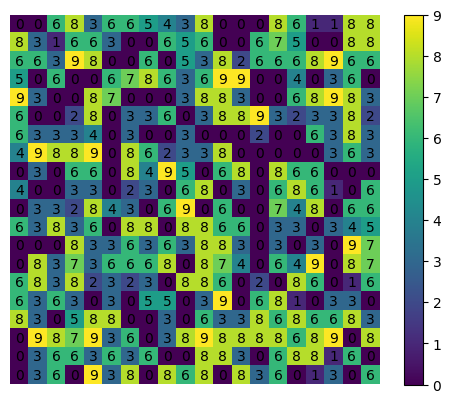

In [20]:
data = label.assignments.to("cpu").detach().numpy()
matrix_data = data.reshape(excitatory_neurons, excitatory_neurons)

# マス目を表示
plt.imshow(matrix_data, cmap="viridis")
for i in range(excitatory_neurons):
    for j in range(excitatory_neurons):
        plt.text(j, i, str(matrix_data[i, j]), ha="center", va="center", color="black")
plt.colorbar()
plt.axis("off")
plt.savefig("./labels", bbox_inches="tight")
plt.show()

In [21]:
# テスト
BATCH_SIZE = 1000
TIME = 350
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
)
encoder = PoissonEncoder(TIME, f_max=64)

model = MNIST(28 * 28, excitatory_neurons**2)
model.load(model_path)
model.to(device)

correct = 0
total = 0

for i, (data, target) in enumerate(tqdm(test_loader, desc="Test")):
    data = encoder(data).to(device)
    firing_rate = model(data, False)
    predict = label.proportion_weighting(firing_rate)

    for target_label, predicted_label in zip(target, predict):
        if target_label == predicted_label:
            correct += 1
        total += 1

accuracy = correct / total
print("Accuracy:", accuracy)

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy: 0.8139
